# IMPORTS

In [1]:
import logging
logging.basicConfig(level=logging.WARN, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

import os, sys
import torch
import numpy as np
import pickle

import classifier as classifier
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

%load_ext autoreload

# %matplotlib notebook
# %matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.close('all')
plt.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

# LOAD CONFIG FILE

In [2]:
config_file_path = "/lscratch/dlopez/Projects/classifier/configs"
config_file_name = "config_Pk_v1_v2.yaml"

config =  classifier.tools.load_config_file(path_to_config=config_file_path, config_file_name=config_file_name)

### Store config file features in local variables

In [3]:
# -------------------- global -------------------- #

path_save = config['path_save']

# -------------------- dataset -------------------- #

path_load = config['path_load']
list_model_names = config['list_model_names']

# -------------------- arquitechture -------------------- #

hidden_layers = config['hidden_layers']

# -------------------- arquitechture -------------------- #

NN_epochs             = config['NN_epochs']
NN_batches_per_epoch  = config['NN_batches_per_epoch']
batch_size            = config['batch_size']
lr                    = config['lr']
weight_decay          = config['weight_decay']
clip_grad_norm        = config['clip_grad_norm']
seed_mode             = config['seed_mode']
seed                  = config['seed']

In [4]:
device = "cuda"
run_name = "manual-sweep-0"
N_threads = classifier.tools.set_N_threads_(N_threads=1)

# LOAD DATASETS

In [5]:
dset_train, dset_val = classifier.tools.load_dset_wrapper(os.path.join(path_load, "TRAIN"), list_model_names, split_ratio=0.8)
dset_test = classifier.tools.load_dset_wrapper(os.path.join(path_load, "TEST"), ["ModelExtrapolation"], split_ratio=None)

### Validation plots for the loaded dataset

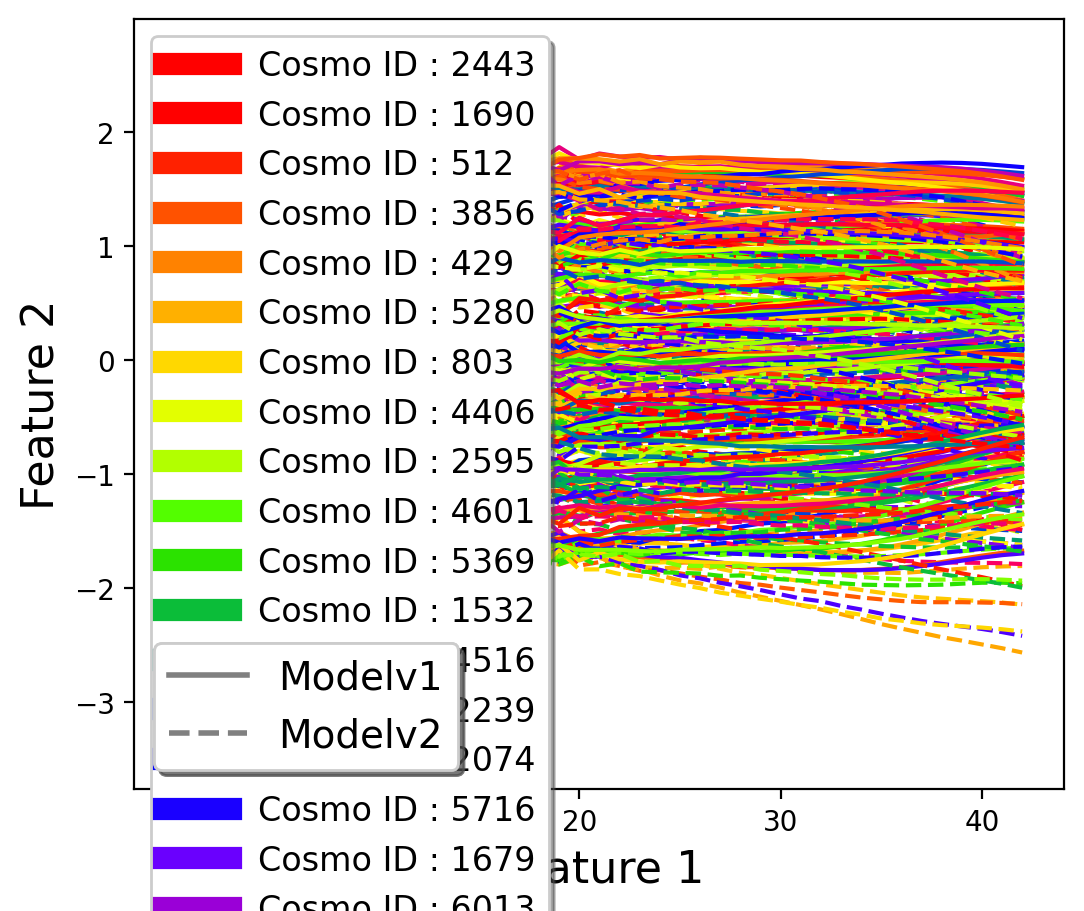

In [6]:
xx_batch_train, yy_batch_train, IDs_batch_train = dset_train(batch_size=len(dset_train.yy), seed=0, to_torch=False, device="cpu", return_IDs=True)


fig, ax = mpl.pyplot.subplots(1,1, figsize=(6,5))

ax.set_xlabel(r'Feature 1', fontsize=16)
ax.set_ylabel(r'Feature 2', fontsize=16)

list_target_IDs = np.random.choice(IDs_batch_train, size=256, replace=False)
colors = classifier.tools.get_N_colors(len(list_target_IDs), mpl.colormaps['prism'])
custom_lines = []
custom_labels = []
custom_lines1 = []
custom_labels1 = []
custom_lines1 = [
    mpl.lines.Line2D([0], [0], color="grey", ls='-', lw=2),
    mpl.lines.Line2D([0], [0], color="grey", ls='--', lw=2)
]
custom_labels1= [
    "Modelv1",
    "Modelv2"
]
for jj, target_ID in enumerate(list_target_IDs):
    tmp_IDs = np.where(IDs_batch_train == target_ID)[0]
    if len(tmp_IDs) == 2:
        custom_lines.append(mpl.lines.Line2D([0], [0], color=colors[jj], ls='-', lw=8))
        custom_labels.append("Cosmo ID : " + str(target_ID))
        for ii, ID in enumerate(tmp_IDs):
            if yy_batch_train[ID] == 0:
                ls = '-'
                marker = "o"
            else:
                ls = '--'
                marker = "x"
            ax.plot(xx_batch_train[ID], color=colors[jj], ls=ls)
            # ax.scatter(xx_batch_train[ID, 0], xx_batch_train[ID, -1], color=colors[jj], ls=ls, marker=marker)

legend = ax.legend(custom_lines, custom_labels, loc='upper left', fancybox=True, shadow=True, fontsize=12)
ax.add_artist(legend)
legend = ax.legend(custom_lines1, custom_labels1, loc='lower left', fancybox=True, shadow=True, fontsize=14)
ax.add_artist(legend)

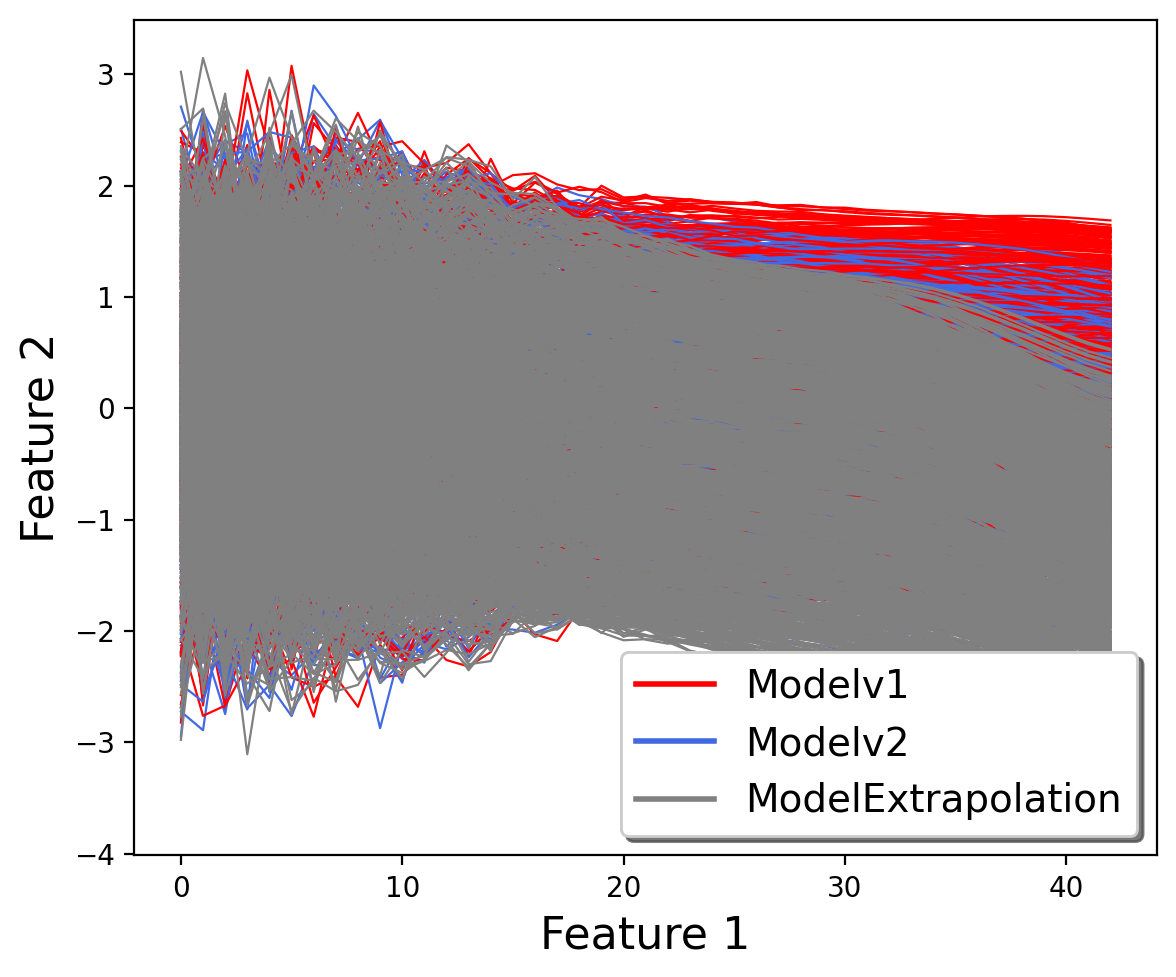

In [7]:
xx_batch_train, yy_batch_train = dset_train(1024)
xx_batch_test, yy_batch_test = dset_test(1024)

fig, ax = mpl.pyplot.subplots(1,1, figsize=(6,5))

ax.set_xlabel(r'Feature 1', fontsize=16)
ax.set_ylabel(r'Feature 2', fontsize=16)

colors = np.zeros_like(yy_batch_train).astype(np.str_)
colors[yy_batch_train == 0] = 'red'
colors[yy_batch_train == 1] = 'royalblue'
for ii in range(yy_batch_train.shape[0]):
    # ax.scatter(xx_batch_train[ii, 0], xx_batch_train[ii, -1], color=colors[ii], marker='o')
    ax.plot(xx_batch_train[ii], color=colors[ii], ls='-', lw=0.8)


for ii in range(xx_batch_test.shape[0]):
    # ax.scatter(xx_batch_test[ii, 0], xx_batch_test[ii, -1], color='grey', marker='+')
    ax.plot(xx_batch_test[ii], color='grey', ls='-', lw=0.8)

custom_lines1 = [
    mpl.lines.Line2D([0], [0], color="red", ls='-', lw=2),
    mpl.lines.Line2D([0], [0], color="royalblue", ls='-', lw=2),
    mpl.lines.Line2D([0], [0], color="grey", ls='-', lw=2)
]
custom_labels1= [
    "Modelv1",
    "Modelv2",
    "ModelExtrapolation"
]
legend = ax.legend(custom_lines1, custom_labels1, loc='lower right', fancybox=True, shadow=True, fontsize=14)
ax.add_artist(legend)

plt.tight_layout()
plt.show()

# DEFINE MODEL(S)

In [8]:
model = classifier.tools.create_mlp(
    input_dim = dset_train.xx.shape[-1], # Number of input features
    hidden_layers = hidden_layers,
    output_dim = len(np.unique(dset_train.yy))  # Number of classes
    )

In [9]:
model

Sequential(
  (0): Linear(in_features=43, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=2, bias=True)
)

# TRAIN MODEL

In [10]:
xx, yy = dset_train(batch_size=len(dset_train.yy), seed=0, to_torch=True, device="cpu")
num_classes = len(torch.unique(yy))
class_counts = torch.bincount(yy)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()  # Normalize
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

In [11]:
logging.info('Training CL model...')

path_save = os.path.join(path_save, run_name)

min_val_loss = classifier.tools.train_model(
    dset_train =dset_train,
    model = model,
    loss_function = loss_function,
    NN_epochs=NN_epochs,
    NN_batches_per_epoch=NN_batches_per_epoch,
    batch_size=batch_size,
    lr=lr,
    weight_decay=weight_decay,
    clip_grad_norm=clip_grad_norm,
    seed_mode=seed_mode, # 'random', 'deterministic' or 'overfit'
    seed=seed, # only relevant if mode is 'overfit'
    dset_val=dset_val, path_save=path_save
)

/cosmos_storage/home/dlopez/miniconda3/envs/VE/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


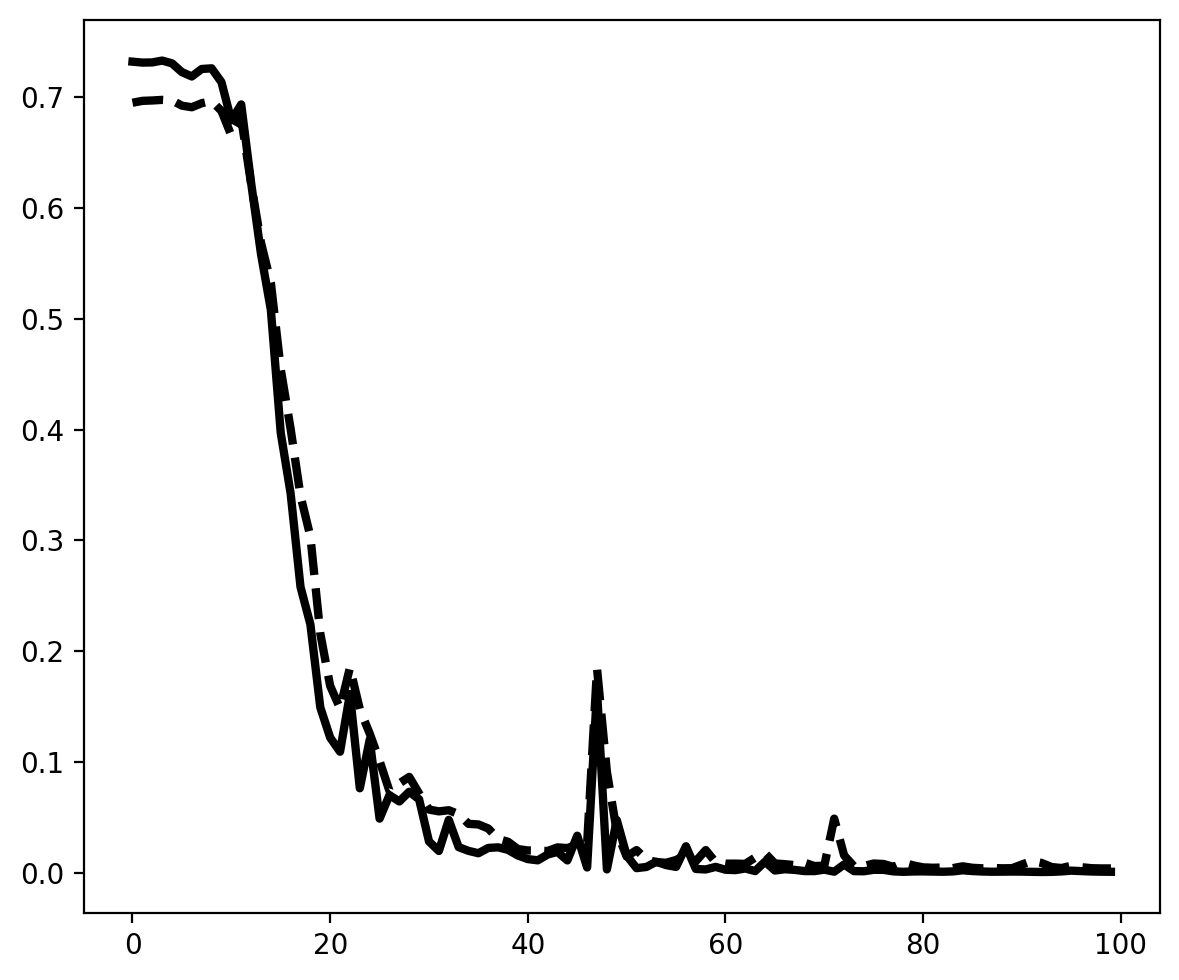

In [12]:
losses = np.loadtxt(os.path.join(path_save, 'register.txt'))

custom_lines = [
    mpl.lines.Line2D([0], [0], color='k', ls='-', lw=3, marker=None, markersize=9),
    mpl.lines.Line2D([0], [0], color='k', ls='--', lw=3, marker=None, markersize=9)
]

fig, ax = mpl.pyplot.subplots(1,1, figsize=(6,5))

ax.plot(losses[:, 0], c='k', lw=3, ls='-')
ax.plot(losses[:, 1], c='k', lw=3, ls='--')

plt.tight_layout()
plt.show()

# EVALUATION

In [13]:
xx, yy_true = dset_val(batch_size=len(dset_val.yy), seed=0, to_torch=True, device="cpu")
model.eval()
with torch.no_grad():
    model_out = model(xx)
yy_pred_P = torch.nn.functional.softmax(model_out, dim=1)
yy_pred_P = yy_pred_P.cpu().numpy()
yy_true = yy_true.cpu().numpy()
xx = xx.cpu().numpy()

thershold = 0.5
yy_pred = (yy_pred_P[:,1] > thershold).astype(np.int32)

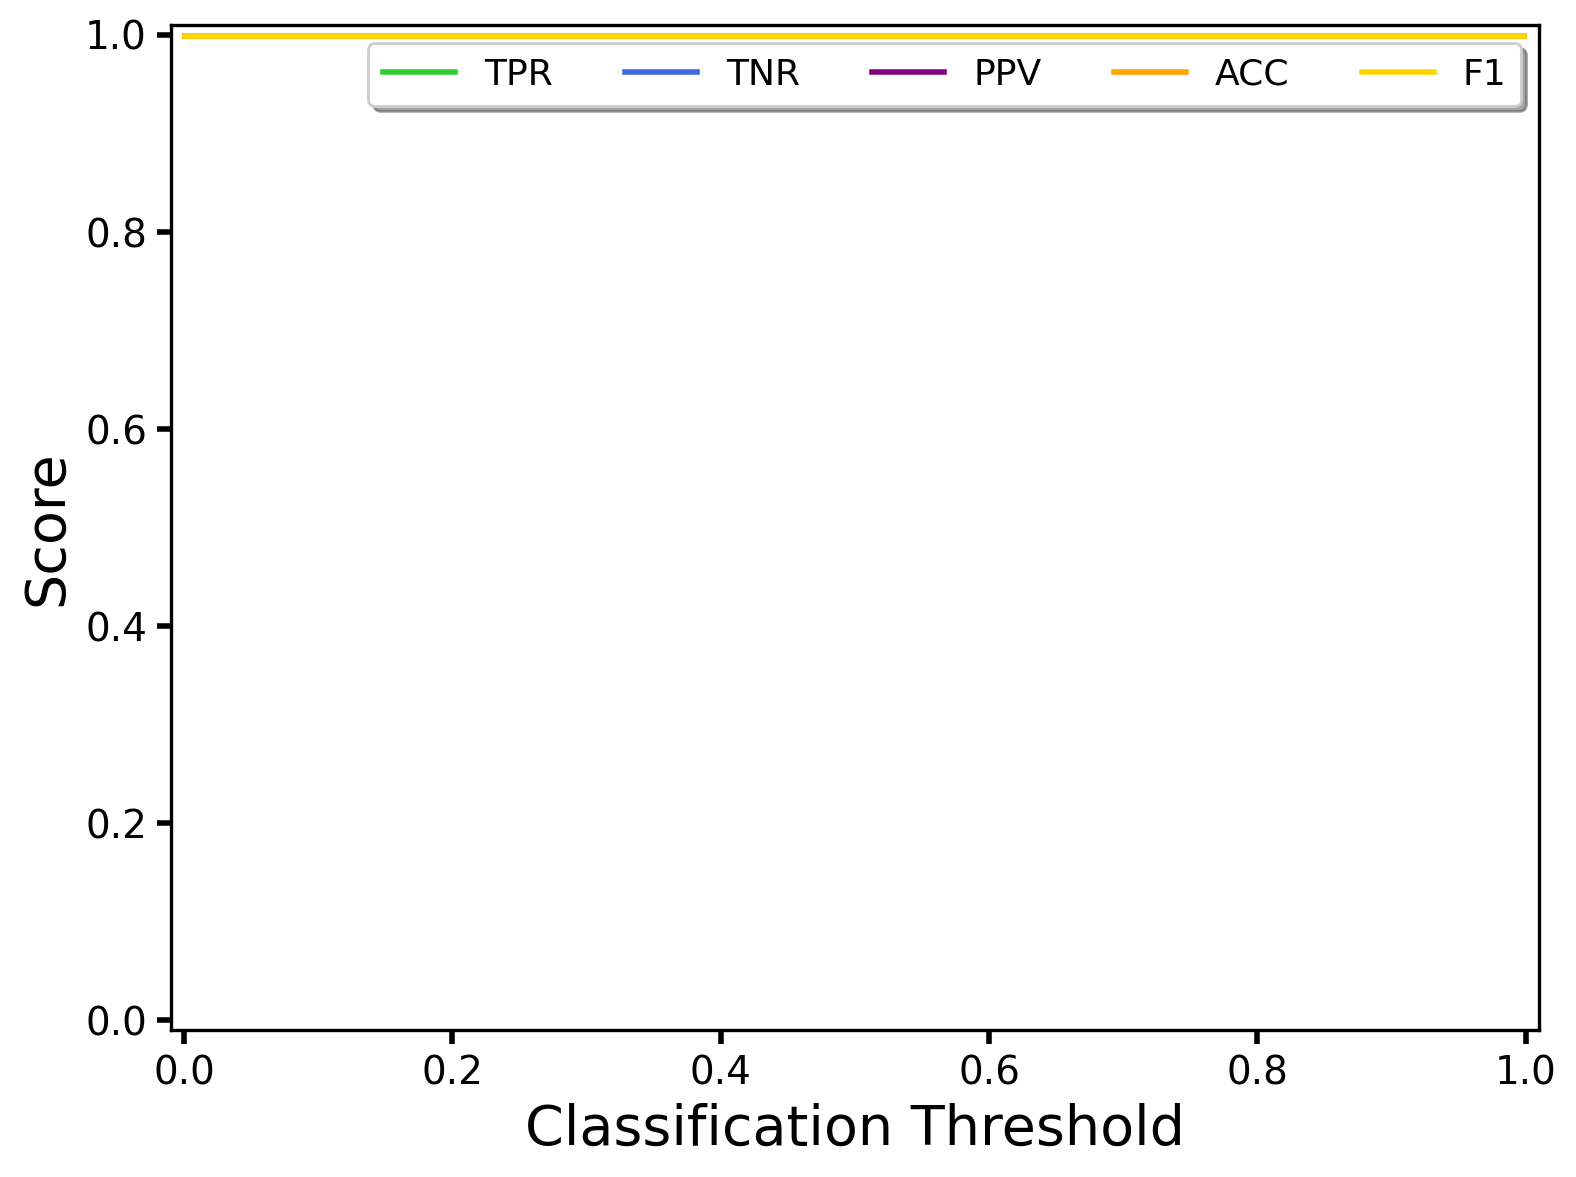

In [14]:
list_classification_thresholds, classification_metrics = classifier.tools.classification_predictions_metrics_vs_thresholds(
    true = yy_true,
    pred = yy_pred
)
fig = classifier.tools.plot_classification_metrics_vs_classification_threshold(
    list_classification_thresholds,
    classification_metrics
)

In [15]:
TN = ( (1-yy_pred.astype(np.int32)) * (1-yy_true.astype(np.int32))).astype(np.int32) * 1
FN = ( (1-yy_pred.astype(np.int32)) * yy_true.astype(np.int32)).astype(np.int32) * 2
FP = (yy_pred.astype(np.int32) * (1-yy_true.astype(np.int32))).astype(np.int32) * 3
TP = (yy_pred.astype(np.int32) * yy_true.astype(np.int32)).astype(np.int32) * 4
classification_labels = FN + TP + TN + FP

percentages_metrics = []
for ii in range(4):
    percentages_metrics.append(round(len(np.where(classification_labels == ii + 1)[0]) * 100 / len(yy_pred_P), 2))

colors = ['royalblue', 'orange', 'red', 'limegreen']
labels = ['TN', 'FN', 'FP', 'TP']
markers = ['o', 'x', 's', 'd']

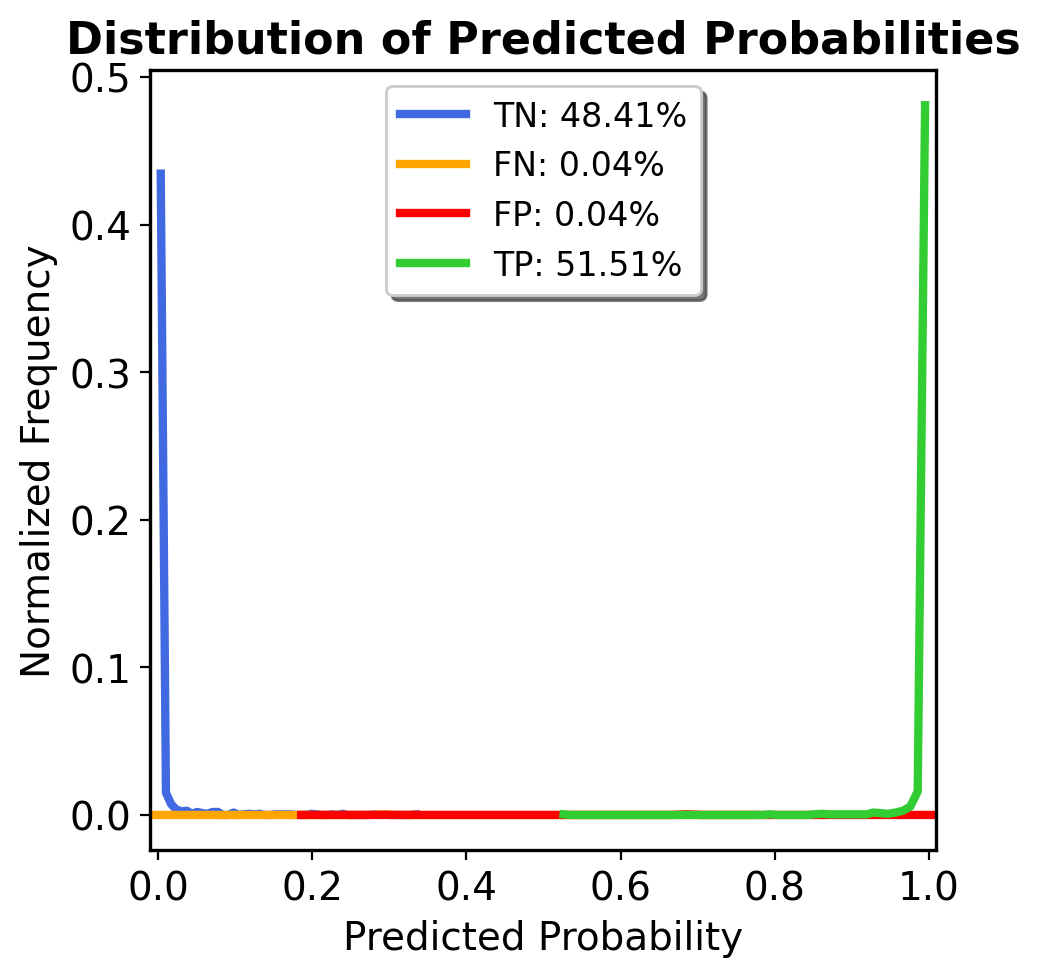

In [16]:
colors = ['royalblue', 'orange', 'red', 'limegreen']
labels = ['TN', 'FN', 'FP', 'TP']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel("Predicted Probability", fontsize=14)
ax.set_ylabel("Normalized Frequency", fontsize=14)
ax.set_title("Distribution of Predicted Probabilities", fontsize=16, fontweight="bold")

custom_lines = []
custom_labels = []
for ii in range(4):
    tmp_mask = np.where(classification_labels == ii + 1)[0]
    tmp_hist = yy_pred_P[:, 1][tmp_mask]
    
    custom_lines.append(mpl.lines.Line2D([0], [0], color=colors[ii], ls='-', lw=3.))
    custom_labels.append(labels[ii] + ": " + str(percentages_metrics[ii]) + "%")
    
    if len(tmp_hist) > 0:
        counts, bin_edges = np.histogram(tmp_hist, bins=50, range=(np.min(tmp_hist), np.max(tmp_hist)))
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        tmp_y_hist = np.array(counts) / len(yy_pred_P[:, 1])

        ax.plot(bin_centers, tmp_y_hist, color=colors[ii], lw=3., linestyle='-')

ax.set_xlim(-0.01, 1.01)
# ax.set_ylim(-0.01, 1.01)

ax.tick_params(axis='both', labelsize=14)

legend = ax.legend(custom_lines, custom_labels, loc='upper center', fancybox=True, shadow=True, fontsize=12)
ax.add_artist(legend)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()


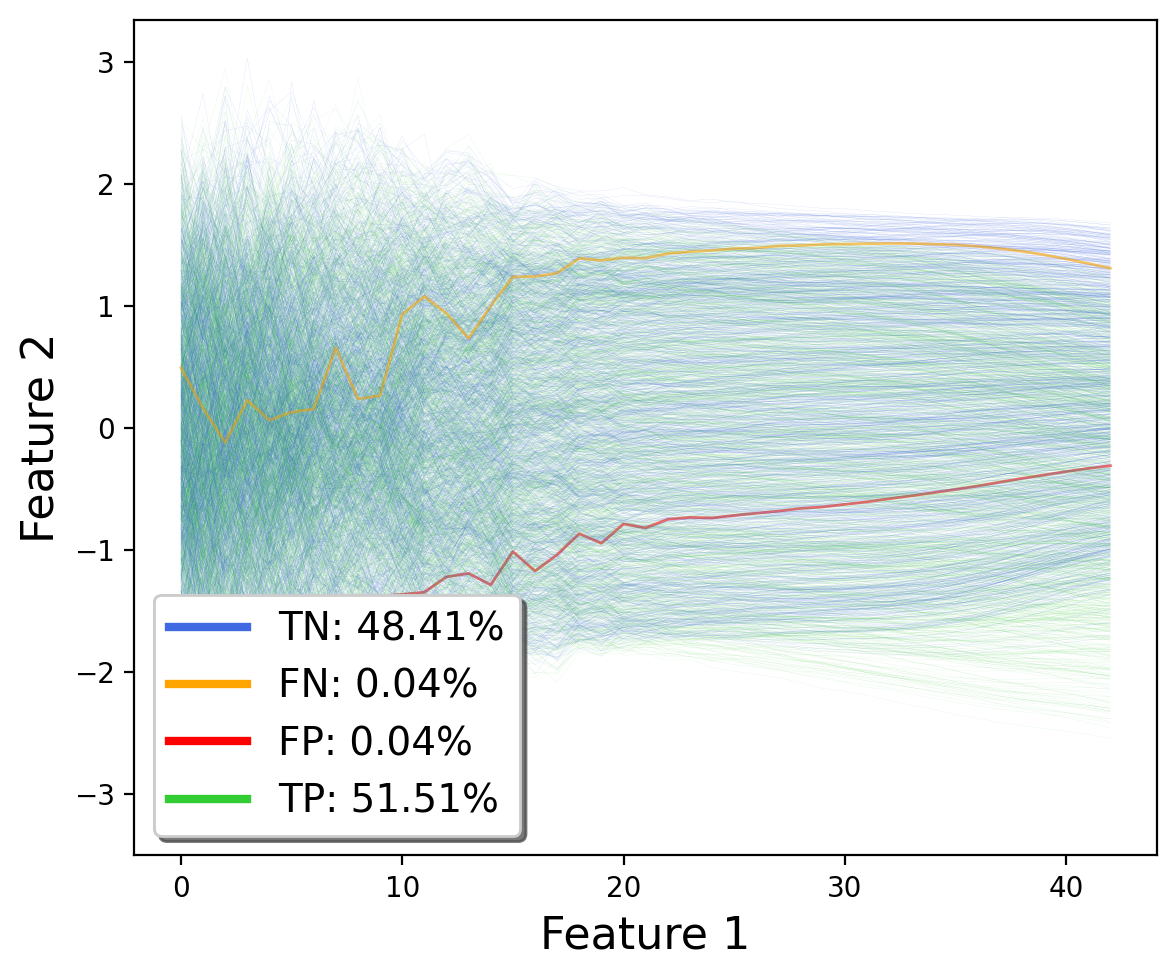

In [17]:
fig, ax = mpl.pyplot.subplots(1,1, figsize=(6,5))

ax.set_xlabel(r'Feature 1', fontsize=16)
ax.set_ylabel(r'Feature 2', fontsize=16)

idxs = np.random.choice(xx.shape[0], size=xx.shape[0], replace=False)

for ii, idx in enumerate(idxs):
    ax.plot(
        xx[idx], color=colors[classification_labels[idx]-1], ls='-', alpha=0.6,
        lw=((100 - percentages_metrics[classification_labels[idx]-1])/100)**5
    )

    # ax.scatter(
    #     xx[idx, 0], xx[idx, -1], color=colors[classification_labels[idx]-1], ls='-', alpha=0.6, marker=markers[classification_labels[idx]-1],
    #     s=((100 - percentages_metrics[classification_labels[idx]-1])/100)**5
    #     )

custom_lines = [
    mpl.lines.Line2D([0], [0], color='royalblue', ls='-', lw=3.),
    mpl.lines.Line2D([0], [0], color='orange', ls='-', lw=3.),
    mpl.lines.Line2D([0], [0], color='red', ls='-', lw=3.),
    mpl.lines.Line2D([0], [0], color='limegreen', ls='-', lw=3.)
]
custom_labels = [
    "TN: " + str(percentages_metrics[0]) + "%",
    "FN: " + str(percentages_metrics[1]) + "%",
    "FP: " + str(percentages_metrics[2]) + "%",
    "TP: " + str(percentages_metrics[3]) + "%"
]
legend = ax.legend(custom_lines, custom_labels, loc='lower left', fancybox=True, shadow=True, fontsize=14)
ax.add_artist(legend)

plt.tight_layout()
plt.show()

# SAVE

In [18]:
# if run_name:
#     path_save = os.path.join(path_save, run_name)
# if not os.path.isdir(path_save):
#     os.makedirs(path_save)

# logging.info('Saving SBI model: ' + path_save + '...')

# with open(os.path.join(path_save, "posterior.pkl"), "wb") as handle:
#     pickle.dump(posterior, handle)
# with open(os.path.join(path_save, "inference.pkl"), "wb") as handle:
#     pickle.dump(inference, handle)    

# logging.info('Model and metadata saved successfully.')

# # loss = inference.summary['best_validation_log_prob'][0]
# loss = inference.summary["best_validation_loss"][0]